In [3]:
import h5py
import numpy as np

PATH = "/dls/science/users/lqg38422/data/12923/12923.nxs"
h5py_list = h5py.File(PATH, "r")

n_darks = 20 #0-19
n_flats = 40 #20-39
n_projections = 1841 #40-1840
n_post_flats = 0
vert_tuple = [i for i in range(400,1000)]
crop_horiz = np.s_[400:800]

darks = h5py_list['/entry1/instrument/flyScanDetector/data'][:n_darks,vert_tuple,crop_horiz]
pre_flats = h5py_list['/entry1/instrument/flyScanDetector/data'][n_darks:n_flats,vert_tuple,crop_horiz]
projData3D_noisy  = h5py_list['/entry1/instrument/flyScanDetector/data'][n_flats:n_projections,vert_tuple,crop_horiz]
post_flats = h5py_list['/entry1/instrument/flyScanDetector/data'][n_projections:n_post_flats,vert_tuple,crop_horiz]
flats = np.concatenate((pre_flats, post_flats))

darks = darks.transpose(1,0,2)
flats = flats.transpose(1,0,2)
projData3D_noisy = projData3D_noisy.transpose(1,0,2)
#projData3D_analyt = np.zeros_like(projData3D_noisy) #to avoid errors

angles = h5py_list['/entry1/tomo_entry/data/rotation_angle'][:] # extract angles
angles_rad = angles[:1801]*np.pi/180.0
h5py_list.close()

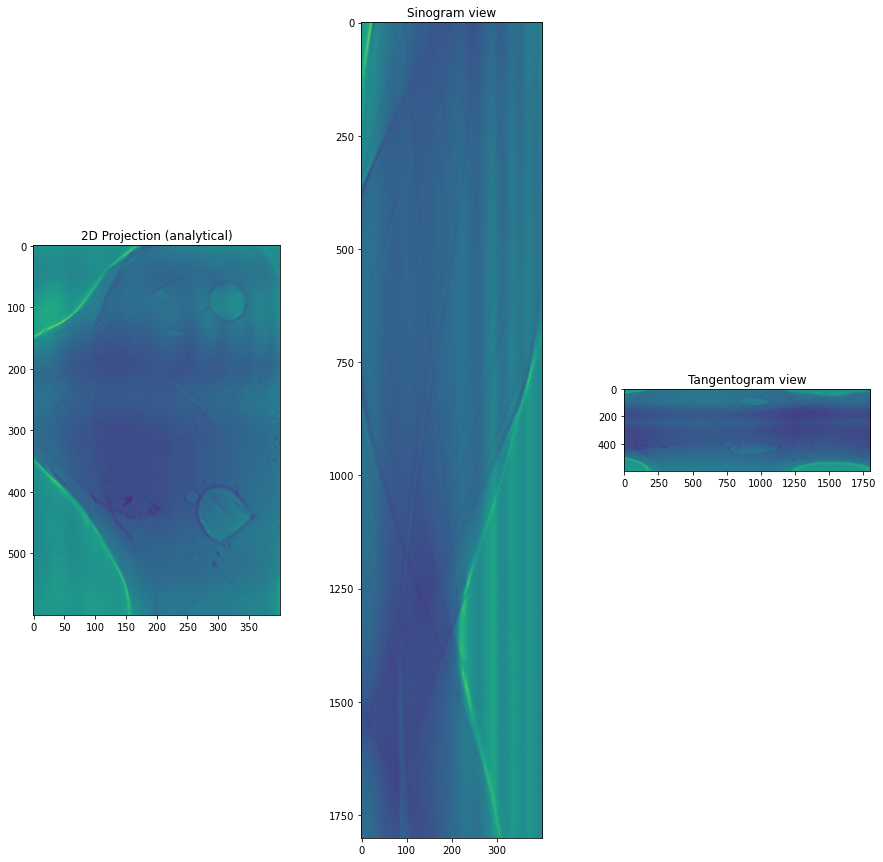

In [4]:
import timeit
import os
import matplotlib.pyplot as plt
import numpy as np
from tomobar.supp.suppTools import normaliser

intens_max_clean = np.max(projData3D_noisy)
sliceSel = 150
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(projData3D_noisy[:,sliceSel,:],vmin=0, vmax=intens_max_clean)
plt.title('2D Projection (analytical)')
plt.subplot(132)
plt.imshow(projData3D_noisy[sliceSel,:,:],vmin=0, vmax=intens_max_clean)
plt.title('Sinogram view')
plt.subplot(133)
plt.imshow(projData3D_noisy[:,:,sliceSel],vmin=0, vmax=intens_max_clean)
plt.title('Tangentogram view')
plt.show()

Normalise projections using ToMoBAR software


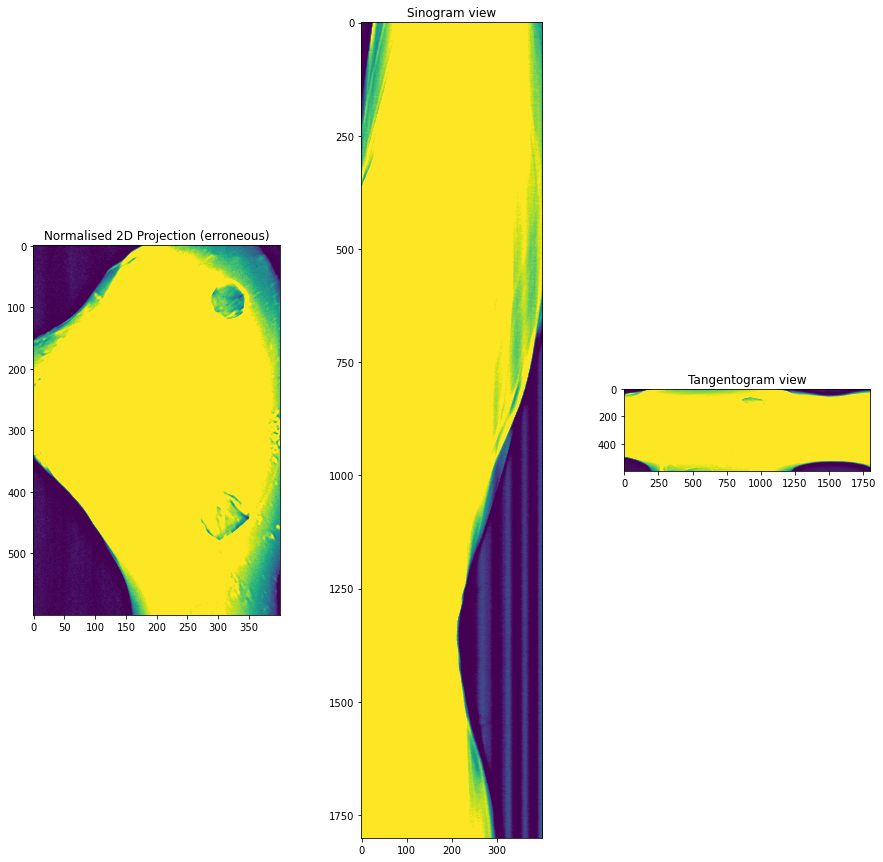

In [5]:
print ("Normalise projections using ToMoBAR software")
# normalise the data, the required data format is [detectorsX, Projections, detectorsY]
projData3D_norm = normaliser(projData3D_noisy, flats, darks=None, log='true', method='mean')

intens_max = 0.15*np.max(projData3D_norm)
sliceSel = 150
plt.figure(figsize=(15,15)) 
plt.subplot(131)
plt.imshow(projData3D_norm[:,sliceSel,:],vmin=0, vmax=intens_max)
plt.title('Normalised 2D Projection (erroneous)')
plt.subplot(132)
plt.imshow(projData3D_norm[sliceSel,:,:],vmin=0, vmax=intens_max)
plt.title('Sinogram view')
plt.subplot(133)
plt.imshow(projData3D_norm[:,:,sliceSel],vmin=0, vmax=intens_max)
plt.title('Tangentogram view')
plt.show()

FBP - Noisy projection
FBP - Split projection


/dls/tmp/lqg38422/noise2inverse/noise2inverse/fig.py:26: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])
/dls/tmp/lqg38422/noise2inverse/noise2inverse/fig.py:27: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_yticks([], [])


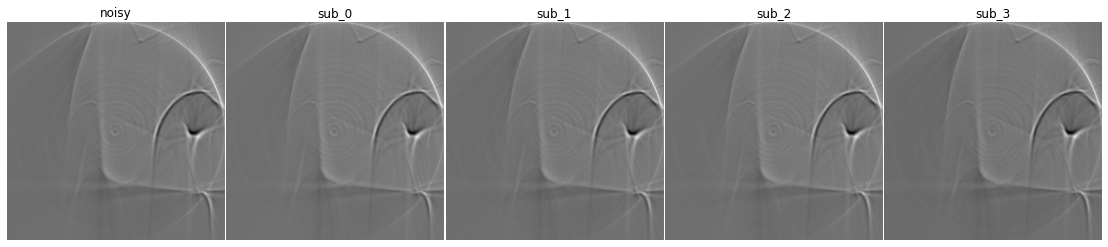

In [6]:
import numpy as np
import torch
from pathlib import Path
from noise2inverse import tiffs, noise, tomo, fig
from tomobar.methodsDIR import RecToolsDIR

num_splits = 4

Vert_det, angles_num, Horiz_det = projData3D_noisy.shape
N_size = Horiz_det

RectoolsDIR = RecToolsDIR(DetectorsDimH = Horiz_det,  # DetectorsDimH # detector dimension (horizontal)
                    DetectorsDimV = Vert_det,  # DetectorsDimV # detector dimension (vertical) for 3D case only
                    CenterRotOffset = None, # Center of Rotation (CoR) scalar (for 3D case only)
                    AnglesVec = angles_rad, # array of angles in radians
                    ObjSize = N_size, # a scalar to define reconstructed object dimensions
                    device_projector = 'gpu')

# Reconstruct clean
# print("FBP - Clean projection")
# clean_rec = RectoolsDIR.FBP(projData3D_analyt) # FBP reconstruction
# clean_rec = torch.tensor(clean_rec)
    
# Reconstruct noisy
print("FBP - Noisy projection")
noisy_rec = RectoolsDIR.FBP(projData3D_norm) # FBP reconstruction
noisy_rec = torch.tensor(noisy_rec)
    
# Reconstruct noisy splits
print("FBP - Split projection")
noisy_splits_rec = [] #/0, /1, /2, ...
for j in range(num_splits):
    RectoolsDIR = RecToolsDIR(DetectorsDimH = Horiz_det,  # DetectorsDimH # detector dimension (horizontal)
                    DetectorsDimV = Vert_det,  # DetectorsDimV # detector dimension (vertical) for 3D case only
                    CenterRotOffset = None, # Center of Rotation (CoR) scalar (for 3D case only)
                    AnglesVec = angles_rad[j::num_splits], # array of angles in radians
                    ObjSize = N_size, # a scalar to define reconstructed object dimensions
                    device_projector = 'gpu')
    sino_split = projData3D_norm[:, j::num_splits, :]
    rec = RectoolsDIR.FBP(sino_split)
    rec = torch.tensor(rec)
    noisy_splits_rec.append(rec)
noisy_splits_rec = torch.stack(noisy_splits_rec)
    
# Show results
slice_num = 450 #len(noisy_splits_rec[0]) // 2
#slice_clean = clean_rec[slice_num,:,:]
slice_noisy = noisy_rec[slice_num,:,:]
slice_0 = noisy_splits_rec[0,slice_num,:,:]
slice_1 = noisy_splits_rec[1,slice_num,:,:]
slice_2 = noisy_splits_rec[2,slice_num,:,:]
slice_3 = noisy_splits_rec[3,slice_num,:,:]

fig.plot_imgs(
    #clean=slice_clean,
    noisy=slice_noisy,
    sub_0=slice_0,
    sub_1=slice_1,
    sub_2=slice_2,
    sub_3=slice_3, 
    width=20.0,
)

In [7]:
torch.cuda.empty_cache() #before we start training

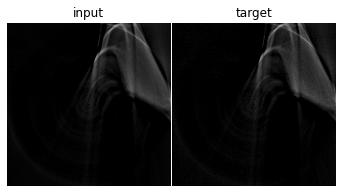

In [8]:
%matplotlib inline

import torch
from noise2inverse.datasets import (
    TiffDataset,
    Noise2InverseDataset,
)
from msd_pytorch import MSDRegressionModel
from torch.utils.data import DataLoader
from tqdm import tqdm

# Parameters
train_dir = Path("reconstructions")
output_dir = Path("weights")

num_splits = 4
strategy = "X:1"
epochs = 8 #100
batch_size = 16
multi_gpu = True
# Scale pixel intensities during training such that its values roughly occupy the range [0,1].
# This improves convergence.
data_scaling = 200

datasets = noisy_splits_rec.unsqueeze(2) #replace TiffDataset for np.array
#datasets = [TiffDataset(train_dir / f"{j}/*.tif") for j in range(num_splits)]
train_ds = Noise2InverseDataset(*datasets, strategy=strategy) #[256, 1, 256, 256] x4

fig.plot_imgs(
    input=train_ds[0][0].detach().squeeze(),
    target=train_ds[0][1].detach().squeeze(),
    vmin=0,
    vmax=0.008,
)

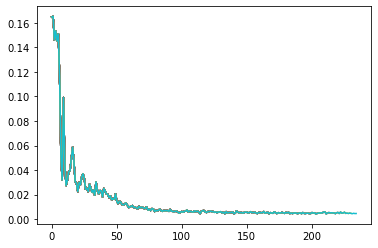

 57%|█████▋    | 86/150 [01:41<01:15,  1.18s/it]


KeyboardInterrupt: 

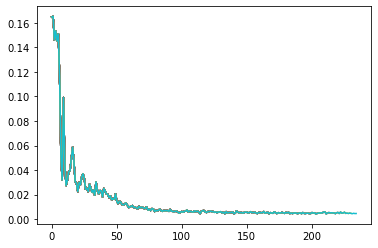

In [9]:
# Dataloader and network:
dl = DataLoader(train_ds, batch_size, shuffle=True,)
model = MSDRegressionModel(1, 1, 100, 1, parallel=multi_gpu)

output_dir.mkdir(exist_ok=True)

# The dataset contains multiple input-target pairs for each slice. 
# Therefore, we divide by the number of splits to obtain the effective number of epochs.
train_epochs = max(epochs // num_splits, 1)

# training loop
from IPython import display
loss_track = []
update_plot = 4
for epoch in range(train_epochs):
    print(f"EPOCH {epoch}: ")
    epoch_loss = []
    it = 0
    # Train
    for (inp, tgt) in tqdm(dl):
        inp = inp.cuda(non_blocking=True) * data_scaling
        tgt = tgt.cuda(non_blocking=True) * data_scaling

        # Do training step with masking
        model.output = model.net(inp)
        model.loss = model.criterion(model.output, tgt)
        # Loss
        epoch_loss.append(model.loss.item())
        loss_track.append(model.loss.item())
        if it % update_plot == 0:
            plt.plot(loss_track)
            display.clear_output(wait=True)
            display.display(plt.gcf())
        model.optimizer.zero_grad()
        model.loss.backward()
        model.optimizer.step()
        it += 1
    #print(f"EPOCH {epoch} - Mean Loss: {np.mean(epoch_loss)}")
    # Save network 
    #model.save(output_dir / f"weights_epoch_{epoch}.torch", epoch)
    
model.save(output_dir / "weights.torch", epoch)
plt.plot(loss_track)

In [11]:
def normalise(im):
    return (im - im.min())/(im.max() - im.min())

600it [00:27, 21.65it/s]


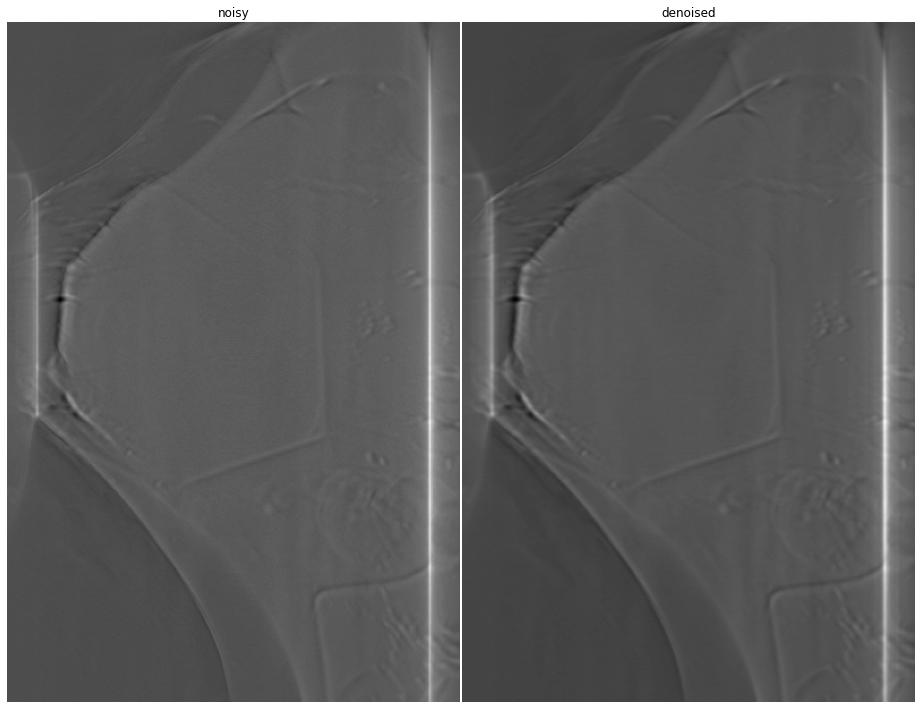

In [29]:
import tifffile
import torch
from noise2inverse.datasets import (
    TiffDataset,
    Noise2InverseDataset,
)
from msd_pytorch import MSDRegressionModel
from torch.utils.data import DataLoader
from tqdm import tqdm

# Parameters
input_dir = Path("reconstructions")
weights_path = Path("weights/weights.torch")
output_dir = Path("denoised")

num_splits = 4
strategy = "X:1"
batch_size = num_splits
multi_gpu = True
# Scale pixel intensities in the same way as during training.
data_scaling = 200

# Output dir
output_dir.mkdir(exist_ok=True)

datasets = noisy_splits_rec.unsqueeze(2) #[TiffDataset(input_dir / f"{j}/*.tif") for j in range(num_splits)]
ds = Noise2InverseDataset(*datasets, strategy=strategy)

# Dataloader and network:
dl = DataLoader(ds, batch_size, shuffle=False,)
model = MSDRegressionModel(1, 1, 100, 1,parallel=True)
model.load(weights_path)

# Put network in evaluation mode: this should be done when the network uses batch norm for instance.
model.net.eval()
denoised_rec = []
with torch.no_grad():
    for i, batch in tqdm(enumerate(dl)):
        inp, _ = batch     
        inp = inp.cuda() * data_scaling
        out = model.net(inp)
        # Take mean over batch dimension (splits):
        out = out.mean(dim=0) / data_scaling
        # Obtain 2D numpy array
        out_np = out.detach().cpu().numpy().squeeze()
        denoised_rec.append(out_np)
denoised_rec = np.array(denoised_rec)

slice_num = 100
fig.plot_imgs(
    #clean=normalise(clean_rec[slice_num,:,:]), #projData3D_analyt
    noisy=normalise(noisy_rec[:,slice_num,:]), #projData3D_norm
    denoised=normalise(denoised_rec[:,slice_num,:]),
    vmin=0,
    vmax=1,
    width=25,
)